In [0]:
print ("Et tumor Brute?")

Et tumor Brute?

The following command lets us access another notebook wherein we located path files to the mounts

In [0]:
%run "./config"

In [0]:
data_folder_path

Out[6]: '/mnt/1stdatalake/data'

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType,  DoubleType

First we have to read the .csv data placed in our container

In [0]:
data_schema=StructType(fields=[StructField("Image",StringType(), False),
                                   StructField("Class",IntegerType(), False),
                                   StructField("Mean",DoubleType(), True),
                                   StructField("Variance",DoubleType(), True),
                                   StructField("Standard Deviation",DoubleType(), True),
                                   StructField("Entropy",DoubleType(), True),
                                   StructField("Skewness",DoubleType(), True),
                                   StructField("Kurtosis",DoubleType(), True),
                                   StructField("Contrast",DoubleType(), True),
                                   StructField("Energy",DoubleType(), True),
                                   StructField("ASM",DoubleType(), True),
                                   StructField("Homogeneity",DoubleType(), True),
                                   StructField("Dissimilarity",DoubleType(), True),
                                   StructField("Correlation",DoubleType(), True),
                                   StructField("Coarseness",DoubleType(), True),

                          
                                  ])

In [0]:
input_df=spark.read\
.option("header",True) \
.schema(data_schema) \
.csv(f"{data_folder_path}/Brain Tumor.csv")

In [0]:
base_df=input_df

In [0]:
#display(base_df)
base_df.show(1)

+------+-----+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+
 Image|Class| Mean| Variance|Standard Deviation| Entropy| Skewness| Kurtosis| Contrast| Energy| ASM| Homogeneity| Dissimilarity| Correlation| Coarseness|
+------+-----+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+
Image1| 0|6.53533935546875|619.587844574841| 24.891521539971|0.109059009370733|4.27647702615029|18.9005747905553|98.6139705882353|0.293314496659804|0.086033393950794|0.530941131652007|4.47334558823529|0.981938696883038|7.45834073119875E...|
+------+-----+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+
only showing top 1 row

In [0]:
from pyspark.sql.functions import col,length
import matplotlib.pyplot as plt

Before we delve into anything serious , we should check if there are no unwanted values in our columns. In this case we knew beforehand that the data does not include any *na* - * not a number* or infinty.

In [0]:
print((base_df.count(), len(base_df.columns)))
base_df.na.drop()#.show()
print((base_df.count(), len(base_df.columns)))

(3762, 15)
(3762, 15)

Following code aim to turn our DataFrame into more manageable ones that can be used for graphs and ML models. data and base_dfare the same except for the class column

In [0]:
base_df=base_df.drop('Image')
print((base_df.count(), len(base_df.columns)))

data=base_df

data=data.drop('Class')
print((data.count(), len(data.columns)))
tumor=base_df.select(col("Class"))
print((tumor.count(), len(tumor.columns)))

(3762, 14)
(3762, 13)
(3762, 1)

We have two DataFrames, one with pure data - our numerical features (eg. Class, Curtosis, ...), one with only 1 column - class, representing either a negative oor positive tumor diagnosis.

In [0]:
data.columns

Out[15]: ['Mean',
 'Variance',
 'Standard Deviation',
 'Entropy',
 'Skewness',
 'Kurtosis',
 'Contrast',
 'Energy',
 'ASM',
 'Homogeneity',
 'Dissimilarity',
 'Correlation',
 'Coarseness']

Above and below return the same thing, it's only a precaution too check if the DataFrame works fine.

In [0]:
data.schema.names

Out[16]: ['Mean',
 'Variance',
 'Standard Deviation',
 'Entropy',
 'Skewness',
 'Kurtosis',
 'Contrast',
 'Energy',
 'ASM',
 'Homogeneity',
 'Dissimilarity',
 'Correlation',
 'Coarseness']

*So how many classes equaling 0/1 there are? It represents the number of positive/negative result *

In [0]:
#Class=base_df.select("Class").show(5)
base_df.groupBy('Class').count().show()

+-----+-----+
Class|count|
+-----+-----+
 1| 1683|
 0| 2079|
+-----+-----+

**CORRELATION GRAPHS**

We would like to see how correlated our data in DataFrame are. We want to create a matrix that will show us a plot of variable A against variable B, where A and B are any given column in the DF. We will use *scatter  matrix* found in pandas, and loop through the columns

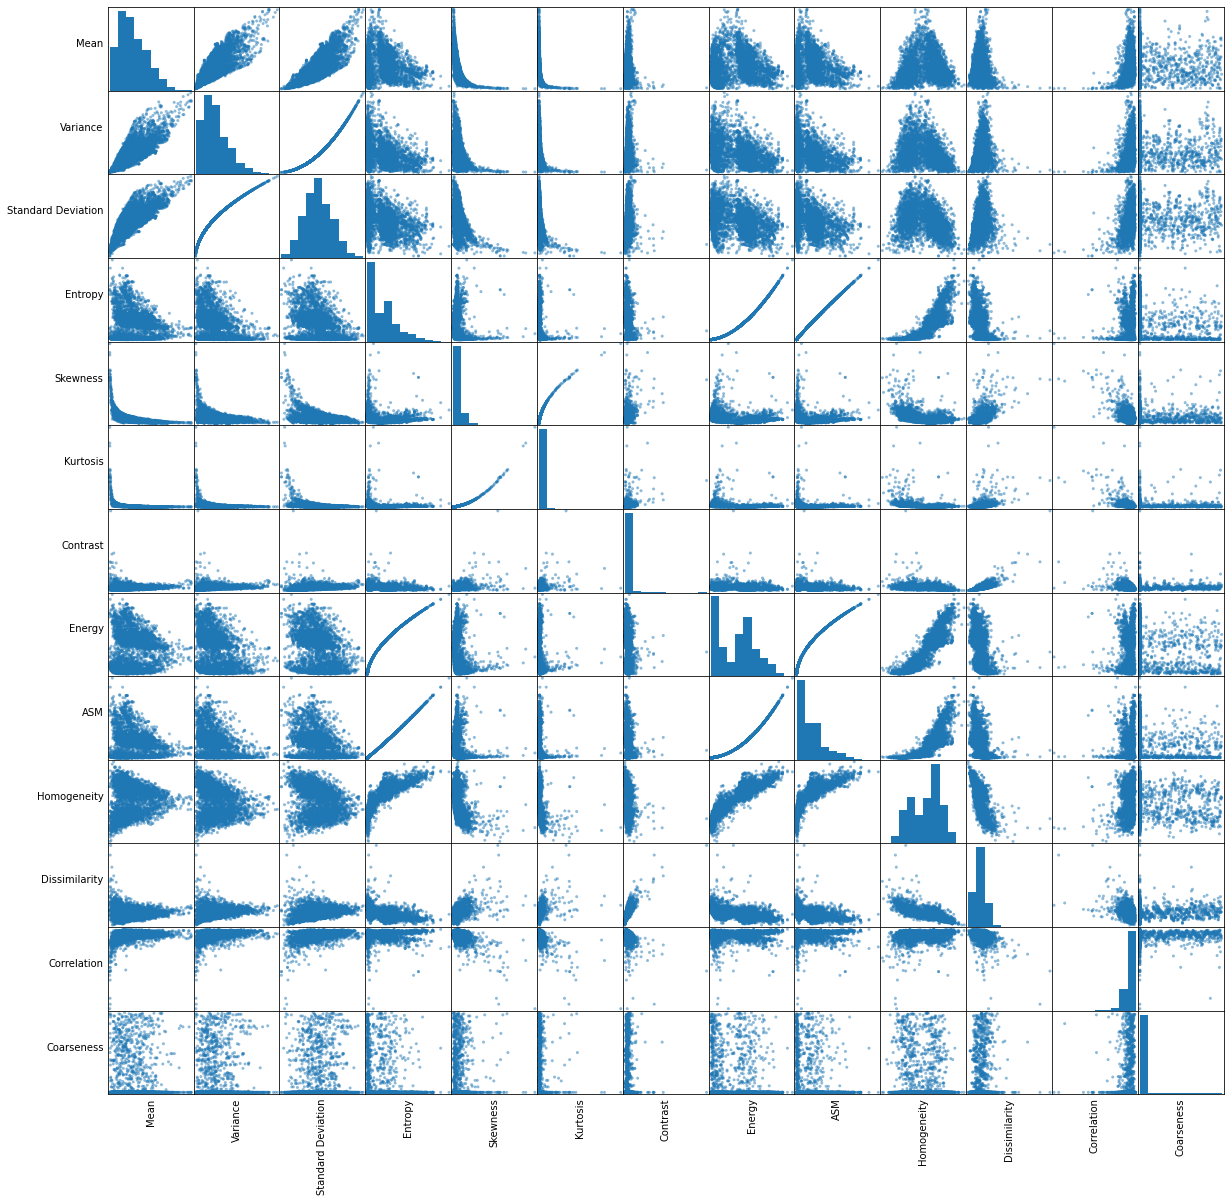

In [0]:
import pandas as pd
pd.DataFrame(base_df.take(15),columns=base_df.columns).transpose()
aux=[ind[0] for ind in base_df.dtypes if ind[1]=='double'] #We only want to play doubles, not any categorical values (though here there are none)
num = base_df.select(aux).toPandas()
ax = pd.plotting.scatter_matrix(num, figsize=(20, 20)); #;alpha=0.5 to make it a bit transparent; way more legible than heatmap from seaborn
n = len(num.columns)
for i in range(n):
    h = ax[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.xaxis.label.set_va('top')
    h.set_xticks(())
    v = ax[i, 0]
    v.yaxis.label.set_rotation(0) #We don't have to rotate those labels, they are horizontal
    v.yaxis.label.set_ha('right')
    v.set_yticks(())


As we see above, there exist both heavily correlated categories and completely unreleated ones. We can also check if a heatmap from seaborn would perhaps be a useful visualization tool.

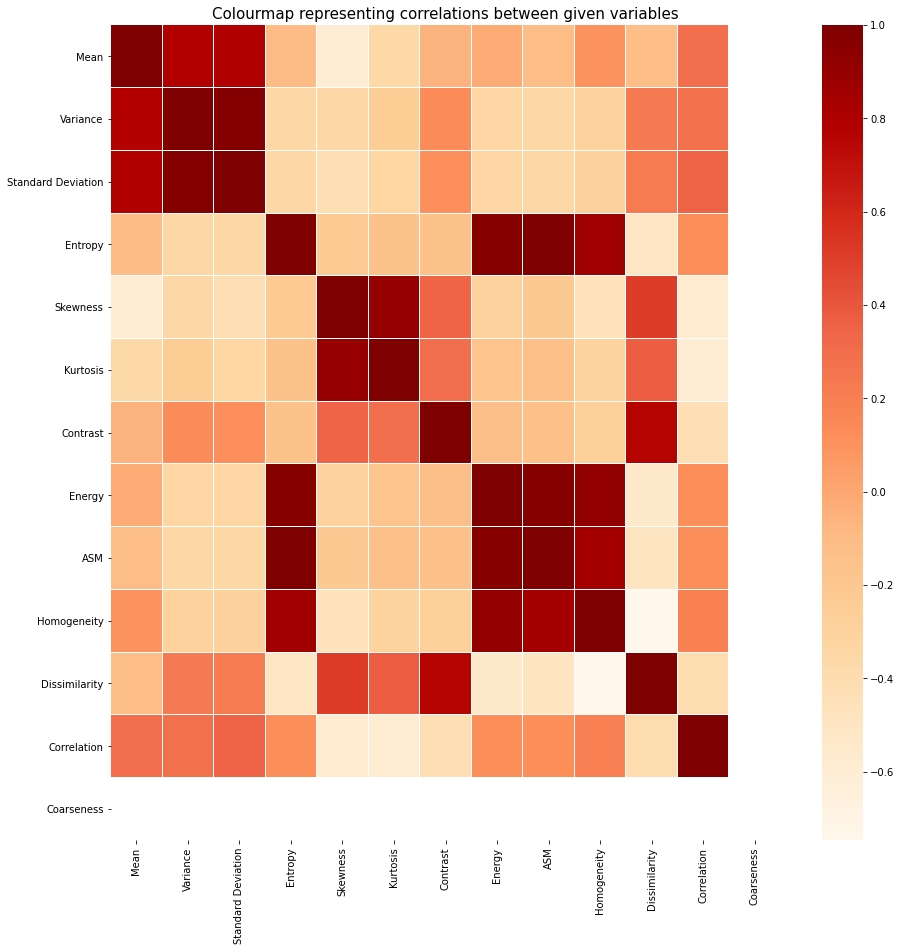

In [0]:
import seaborn as sns
plt.subplots(figsize=(15,15))
plt.title("Colourmap representing correlations between given variables",fontsize=15)
sns.heatmap(num.corr(),linewidths=.05,cmap="OrRd")
plt.show()


Heatmap supports the earlier results from the graph, the more correlated the graph of two variables was and resembled a line, the redder its square got in the heatmap.

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


**Stages and assembler**

This cell looks underwhelming but could be readily expanded should the data contain strings that would need to be transformed using OneHotEncoder and StringIndexer. Said transformations would become stages in our pipeline, thus ensuring quick implementation of both numeric and categorical values into one ready-to-go package. As it happens, in our data frame there are no such columns but the cell remains valid nevertheless. Assembler creates a features vector from named columns but we don't provide it with exact DataFrame yet.

In [0]:
stages=[]
assembler=VectorAssembler(inputCols=['Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness'],outputCol='features')
stages+=[assembler]

#stages+=['Class']####


In [0]:
print(stages)

[VectorAssembler_74a8e4215d8e]

**Pipeline**

We now create a pipeline  - an assembly of several steps that will make it easier to implenent ML models. We need to put our assembler into the pipeline and then fit and transform it with DataFrame.

In [0]:
pipe=Pipeline(stages=stages)
pl=pipe.fit(base_df)
df=pl.transform(base_df)
#display(df)
df.show(1)
selcol=['Class','features','Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness'] #we can pick which columns we would like to consider based on the heatmap and graph, here we decided to take all of them into consideration
df=df.select(selcol)
#display(df)
df.show(1)


+-----+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+--------------------+
Class| Mean| Variance|Standard Deviation| Entropy| Skewness| Kurtosis| Contrast| Energy| ASM| Homogeneity| Dissimilarity| Correlation| Coarseness| features|
+-----+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+--------------------+
 0|6.53533935546875|619.587844574841| 24.891521539971|0.109059009370733|4.27647702615029|18.9005747905553|98.6139705882353|0.293314496659804|0.086033393950794|0.530941131652007|4.47334558823529|0.981938696883038|7.45834073119875E...|[6.53533935546875...|
+-----+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+--------------------+
only showing top 1 row

+-----+--------------------+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+
Class| features| Mean| Variance|Standard Deviation| Entropy| Skewness| Kurtosis| Contrast| Energy| ASM| Homogeneity| Dissimilarity| Correlation| Coarseness|
+-----+--------------------+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+
 0|[6.53533935546875...|6.53533935546875|619.587844574841| 24.891521539971|0.109059009370733|4.27647702615029|18.9005747905553|98.6139705882353|0.293314496659804|0.086033393950794|0.530941131652007|4.47334558823529|0.981938696883038|7.45834073119875E...|
+-----+--------------------+----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+--------------------+
only showing top 1 row

In [0]:
pd.DataFrame(df.take(15),columns=df.columns).transpose() #5

Out[24]:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Class,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0
features,"[6.53533935546875, 619.587844574841, 24.891521...","[8.74996948242188, 805.957633995078, 28.389392...","[7.34109497070313, 1143.80821918438, 33.820233...","[5.95814514160156, 959.711984907359, 30.979218...","[7.31523132324219, 729.540578978274, 27.010008...","[7.52410888671875, 607.395257778402, 24.645390...","[12.3044128417969, 922.746137739561, 30.376736...","[15.9294738769531, 1069.95024757066, 32.710093...","[19.9216156005859, 1166.12092201469, 34.148512...","[8.4761962890625, 1095.7851273195, 33.10264532...","[9.80461120605469, 1114.82965293078, 33.389064...","[12.3267822265625, 1150.6771443364, 33.9216323...","[10.1934661865234, 813.924363430001, 28.529359...","[7.15631103515625, 413.438221306825, 20.333180...","[5.29147338867188, 430.963765610282, 20.759666..."
Mean,6.53534,8.74997,7.34109,5.95815,7.31523,7.52411,12.3044,15.9295,19.9216,8.4762,9.80461,12.3268,10.1935,7.15631,5.29147
Variance,619.588,805.958,1143.81,959.712,729.541,607.395,922.746,1069.95,1166.12,1095.79,1114.83,1150.68,813.924,413.438,430.964
Standard Deviation,24.8915,28.3894,33.8202,30.9792,27.01,24.6454,30.3767,32.7101,34.1485,33.1026,33.3891,33.9216,28.5294,20.3332,20.7597
Entropy,0.109059,0.266538,0.00146681,0.00147712,0.146761,0.214086,0.128833,0.107658,0.0949755,0.00300189,0.00243621,0.00376858,0.00977447,0.0818255,0.354116
Skewness,4.27648,3.71812,5.06175,5.67798,4.28322,3.72989,2.93009,2.484,2.12917,4.365,3.87273,3.62398,3.35913,3.17978,4.36918
Kurtosis,18.9006,14.4646,26.4796,33.4288,19.0791,14.4717,8.96935,6.51589,4.90584,19.6825,15.5529,14.7623,12.1817,10.2873,19.6319
Contrast,98.614,63.8588,81.8672,151.23,174.989,105.078,115.203,94.8743,93.8189,72.5888,66.2855,165.485,110.569,122.403,46.8643
Energy,0.293314,0.475051,0.0319167,0.0320237,0.343849,0.421587,0.320675,0.291321,0.272486,0.0456851,0.04114,0.051321,0.0832839,0.250908,0.55534


**Random split - generating train&test sets**

This procedure is used to create two separate datasets. We will use one, *train* dataset, to do just that - train or fit our ML models on this subset. Test subset will be in turn used to provide us with a final evaluation of how well was did the train subset fit.

In [0]:
train, test = df.randomSplit([0.7, 0.3],seed=1000) # or 0.8,0.2, or 0.75,0.25
print("Training Data Count: " + str(train.count()))
train.groupBy('Class').count().show()
print("Test Data Count: " + str(test.count()))
test.groupBy('Class').count().show()

Training Data Count: 2570
+-----+-----+
Class|count|
+-----+-----+
 1| 1128|
 0| 1442|
+-----+-----+

Test Data Count: 1192
+-----+-----+
Class|count|
+-----+-----+
 1| 555|
 0| 637|
+-----+-----+

We are done with the preparation and can start implementing supervised learning models. We will start with:  
**Logistic Regression**

Logistic regression is one of the most popular ML algorith when dealing with a binary classification. It uses a so called sigmoid function, denoted by sig(t)=1/(1+e^-t). The function 0 and 1 at negative and positive infinty respectively. A  horizontal decision boundary is also created to decide whether we classify values as 1 or 0. Sigmoid returns the probility of the observation being positive. This sigmoid function is used in conjuction with a cost function that we aim to minimize (for example using gradient descent algorithm). 
In order to call a LogReg model on our dataset we need to first import the module from .ml library, call it and detail the label (the binary class column) and the features (all numerical columns). 
After creating a new classifier we ought to show it the train dataset - the model will use said values to *learn*.

In [0]:
from pyspark.ml.classification import LogisticRegression

lr=LogisticRegression(featuresCol='features',labelCol='Class',maxIter=1) #of course we can increas maxIter num
LR=lr.fit(train)


Out[27]:

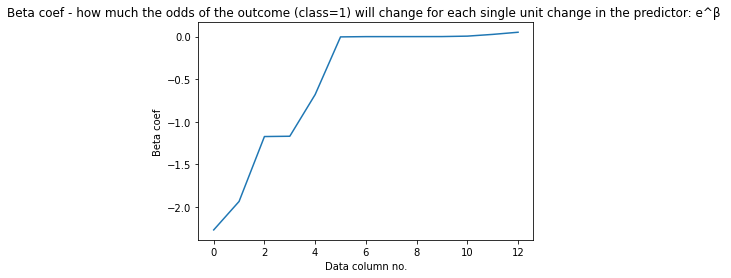

Text(0.5, 0, 'Data column no.')

In [0]:
import matplotlib .pyplot as plt
import numpy as np
beta=np.sort(LR.coefficients) #or...
#beta=(LR.coefficients)
plt.title("Beta coef - how much the odds of the outcome (class=1) will change for each single unit change in the predictor: e^β ")
plt.plot(beta)
plt.ylabel('Beta coef')
plt.xlabel('Data column no.')
#plt.xlabel()


because we have a binary classification we can use .summary as described in spark documentation to measure how well is our model doing. ROC stands for *Receiver Operating Characteristics* which plots True positive rate (TPR=TP/(TP+FN), also known as recall) against  false positive rate (FPR=FP/(FP+TN)). So it shows probability of detection vs probability of false alarm under different threshold. Area Under Curve is an integral of the area below, and can be interpreted as probability of rating a random positive value higher than a random negative - an *AUC* of 0 means 0% percent accurate predictions. 

https://spark.apache.org/docs/latest/ml-classification-regression.html

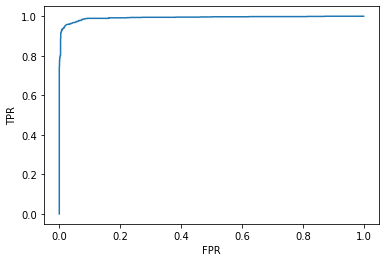

0.9927501082027542

In [0]:
sum=LR.summary
ROC=sum.roc.toPandas()
plt.plot(ROC['FPR'],ROC['TPR'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
print (sum.areaUnderROC)

Precision=TP/TP+FP
Recall=TP/TP+FN

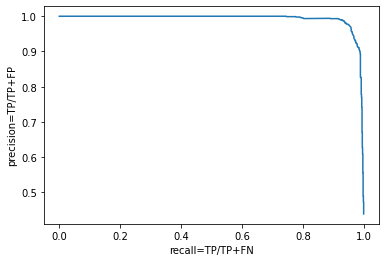

In [0]:

pr=sum.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.xlabel("recall=TP/TP+FN")
plt.ylabel("precision=TP/TP+FP")
plt.show()

In order to find out how accurately can our model classify data, we need to transform the model to the test subset - checking how well it can predict data using train data (the one it was *trained* on) wouldn't make much sense.

In [0]:

predictions = LR.transform(test)
predictions.select('Class','rawPrediction',"prediction",'probability').show(1)  # 'Mean', 'Variance', 'Standard Deviation','Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness'

+-----+--------------------+----------+--------------------+
Class| rawPrediction|prediction| probability|
+-----+--------------------+----------+--------------------+
 0|[3.18614809077754...| 0.0|[0.96030966491590...|
+-----+--------------------+----------+--------------------+
only showing top 1 row

We're importing and calling BinaryClassificationEvaluator and using its method to receive the *AUC*.

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class')
print('LOGREG - Test Area Under ROC', evaluator.evaluate(predictions))

LOGREG - Test Area Under ROC 0.9898680470109021

**DECISION TREE CLASIFIER**

Commonly used in machine learning or as part of more advanced models, DTC is a concept that's easy to visualise as it creates a graph that looks like an upside down tree, starting at roots and ending in leafs. The tree selects the best split from a set of splits that are possible in order to get the largest information gain. The tree employs two kind of nodes: decision nodes and leaf nodes. At each decision nodes branches are created each ending at a new dcision node and so on. The last branches end with a leaf node, a final output. At each decision node the tree finds the best split, so in this case a column that will result in largest information gain and applies possible splitted values to its branches - for example, if 'Mean' value of more than 1.0 would always be connected with negative tumour label, itwould be a perfect candidate for a decision node - it's easy to split the data on this attribute. 

Maximum depth refers to the longest route that can be created from the root to a leaf. 

Tree is however prone to overfit data, which may be further exacerbated if we set a large depth. 

To use RFC we have to import its module from .ml library and initialize it with our features and labels. Then we will use BinaryEvaluator as previously.

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier


In [0]:
dtc=DecisionTreeClassifier(featuresCol='features',labelCol='Class',maxDepth=5)
DTC=dtc.fit(train)
predictions=DTC.transform(test)
predictions.select('Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness').show(1)

+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+----------------+--------------------+
 Mean| Variance|Standard Deviation| Entropy| Skewness| Kurtosis| Contrast| Energy| ASM| Homogeneity| Dissimilarity| Correlation| Coarseness|
+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+----------------+--------------------+
0.307815551757812|10.2153898526946| 3.19615235129594|0.354311538326785|10.9450349168516|124.787253064899|64.4358803986711|0.555279811972505|0.308335669584221|0.730989409598133|2.57940199335548|0.88212481908464|7.45834073119956E...|
+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+----------------+--------------------+
only showing top 1 row

In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class')
print('DTC - Test Area Under ROC', evaluator.evaluate(predictions))

DTC - Test Area Under ROC 0.9687951687951687

a decision tree obtains considerably worse results than log reg, even at its minimal iterations. It's not surprising given multitude of variables. A random forest employs not one but a large number of individual trees so it's only natural we check that method next

**Random Forest Classifier**

Random forest is a popular method thanks its increased performance over the decision tree classifier. It is essentially an ensemble of decision trees and thanks to combining a good few of them we minimize the risk of overfitting (trying to conform way too closely to, say, a few outliers or inaccurate data). Each Tree returns a class prediction on its own. In the end, RFC returns the result that majority of the incorporated Tree Classifier have decided on. A quote that well represents the idea and good results of RFC: "A large number of relatively uncorrelated models opearting as a committe will outperform any of the individual constituent models" (source: https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

To use RFC we have to import its module from .ml library and initialize it with our features and labels. Then we will use BinaryEvaluator as previously.

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rfc=RandomForestClassifier(featuresCol='features',labelCol='Class',maxDepth=5)
rfc.setNumTrees(5)
RFC=rfc.fit(train)
predictions=RFC.transform(test)
predictions.select('Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness').show(5)

+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
 Mean| Variance|Standard Deviation| Entropy| Skewness| Kurtosis| Contrast| Energy| ASM| Homogeneity| Dissimilarity| Correlation| Coarseness|
+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
0.307815551757812|10.2153898526946| 3.19615235129594|0.354311538326785|10.9450349168516|124.787253064899|64.4358803986711|0.555279811972505|0.308335669584221|0.730989409598133| 2.57940199335548| 0.88212481908464|7.45834073119956E...|
0.751556396484375|26.0856798761599| 5.10741420644144|0.237061374384786| 7.6396186255158|64.1620771938391|63.4907407407407|0.445189528703674|0.198193716467399|0.677188261986638| 2.59472934472934|0.902899197844918|7.45834073119875E...|
0.854660034179688|38.6028975386113| 6.21312301009817|0.189241531674144|7.56341065486765| 58.259537421975|111.709692671395| 0.39363256843191|0.154946598930302|0.644802010697303| 3.71063829787234|0.896439615502052|7.45834073119875E...|
 1.09371948242188|11.3959144229586| 3.37578352726573|0.179231251407331|3.64719010883242|14.6512150376029|3.19473319473319|0.376623097086826|0.141844957259273|0.790120235345191|0.681120681120681|0.957850675308719|7.45834073119875E...|
 1.11787414550781|39.9919671954202| 6.32392023948912|0.203139334428764|5.95968401612157|36.0087154247339|64.5859619210003|0.407704855359846|0.166223249083993|0.705089674839605| 2.73543620346689|0.909452751379984|7.45834073119875E...|
+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
only showing top 5 rows

In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class')
print('RFC - Test Area Under ROC', evaluator.evaluate(predictions))

RFC - Test Area Under ROC 0.9939228082085225

**Gradient boosted tree classifier**
Gradient boosting aims to create an ensemble of usually weaker models and is said to often be more accurate than the RFC. 

We have to declare the maximal number of iteration - each one involves adjusting the weights and coefficients in order to minimize the loss function.

In [0]:
from pyspark.ml.classification import GBTClassifier
gbtc=GBTClassifier(featuresCol='features', labelCol='Class',maxIter=20)
GBTC=gbtc.fit(train)
predictions=GBTC.transform(test)
predictions.select('Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness').show(5)

+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
 Mean| Variance|Standard Deviation| Entropy| Skewness| Kurtosis| Contrast| Energy| ASM| Homogeneity| Dissimilarity| Correlation| Coarseness|
+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
0.307815551757812|10.2153898526946| 3.19615235129594|0.354311538326785|10.9450349168516|124.787253064899|64.4358803986711|0.555279811972505|0.308335669584221|0.730989409598133| 2.57940199335548| 0.88212481908464|7.45834073119956E...|
0.751556396484375|26.0856798761599| 5.10741420644144|0.237061374384786| 7.6396186255158|64.1620771938391|63.4907407407407|0.445189528703674|0.198193716467399|0.677188261986638| 2.59472934472934|0.902899197844918|7.45834073119875E...|
0.854660034179688|38.6028975386113| 6.21312301009817|0.189241531674144|7.56341065486765| 58.259537421975|111.709692671395| 0.39363256843191|0.154946598930302|0.644802010697303| 3.71063829787234|0.896439615502052|7.45834073119875E...|
 1.09371948242188|11.3959144229586| 3.37578352726573|0.179231251407331|3.64719010883242|14.6512150376029|3.19473319473319|0.376623097086826|0.141844957259273|0.790120235345191|0.681120681120681|0.957850675308719|7.45834073119875E...|
 1.11787414550781|39.9919671954202| 6.32392023948912|0.203139334428764|5.95968401612157|36.0087154247339|64.5859619210003|0.407704855359846|0.166223249083993|0.705089674839605| 2.73543620346689|0.909452751379984|7.45834073119875E...|
+-----------------+----------------+------------------+-----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
only showing top 5 rows

In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class') #,metricName='areaUnderPR
print('GBTC - Test Area Under ROC', evaluator.evaluate(predictions))

GBTC - Test Area Under ROC 0.9941222226936504

In order to achieve the most precise results we will use Spark's hyperparameter Tuning, using ml.tuning library. 
k-fold cross validation evaluates during every iteration all possible params combination (in parallel). The returned hyperparam metric is the best found among the feasible combinations. 

K-fold cross splits dataset into randomly chosen folds which are used as independent training and test datasets. K constitues the number of train-test pair generated. 
Since Gradient boosted classifier tree provided us with the best results so far, we will be using this model in our CrossValidator as the estimator. 

For each of the aforementined pairs, program will iterate through the whole set declared in ParamMap (also called hyperparameter combination), in paralell fitting the evaluator and in the end returninng the best-performing hyperparameter across the iterations and its results.  

Grid builder has plenty of methods one could tinker with to produce the best results... or exactly the same despite 10 times the calculation times. 

Without doubts this operation will be the most time-consuming one of all in the notebook. However, it may just be worth it as cross validation is "a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning" (source:https://spark.apache.org/docs/latest/ml-tuning.html)

**Grid builder & CrossValidator**

In [0]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
pg=(ParamGridBuilder()\
    .addGrid(gbtc.maxDepth,[2,4,6])\
    .addGrid(gbtc.maxBins,[20,30])\
    .addGrid(gbtc.maxIter,[5,20]).build()) 


In [0]:
#this takes 12 minutes on 8gb 4 core,  [2,4,6,8,10] , 20,50, 5,20 4 fold -> 0.9952890095747237
#this takes 4-5 minutes on 8gb 4 core,  [2,4,6] , 20,30, 5,20 4fold -> 0.9952890095747237
cv=CrossValidator(estimator=gbtc,estimatorParamMaps=pg,evaluator=evaluator,numFolds=4)
CV=cv.fit(train)

/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
predictions=CV.transform(test)
evaluator.evaluate(predictions)

Out[41]: 0.9952890095747237

THIS IS THE BEST RESULT!

**multilayer perceptron**

This model is a classifier based on feedforward artificial neural network. More info can be found here:
https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
Attribute *layers* represents 3 numbers: number of inputs (also called visible layers, often a network is drawn with number of columns as number of inputs), number of neutron on a hidden layer and number of neurons in output layers

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [13,10000,2]

# create the trainer,set params
mlpc = MultilayerPerceptronClassifier(featuresCol='features', labelCol='Class',maxIter=200, layers=layers, blockSize=50)

# train the model
MLPC = mlpc.fit(train)




In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictions = MLPC.transform(test)
predictions.select('Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness', 'Class')
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class')
#evaluator=MulticlassClassificationEvaluator(labelCol='Class',predictionCol='prediction',metricName='f1')

print('ROC', evaluator.evaluate(predictions))

ROC 0.9602132744989872

*naive bayes*
doesn't work good(/at all), maybe we shouldn't be surprised

In [0]:
"""from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0,modelType="Bernoulli") #featuresCol='features', labelCol='Class',smoothing=1.0, modelType="bernoulli"
NB = nb.fit(train,1.0)
predictions = NB.transform(test)
predictions.select('Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness').show(1)


nb=NaiveBayes(smoothing=1.0,modelType='multinomial')
pipeline=Pipeline(stages=[assembler,nb])
NB=nb.fit(train)
predictions=NB.transform(test)
predictions.show(5)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="precision")
accuracy = evaluator.evaluate(predictions)
print ("Accuracy: ", accuracy)

"""


Out[58]: 'from pyspark.ml.classification import NaiveBayes\nnb = NaiveBayes(smoothing=1.0,modelType="Bernoulli") #featuresCol=\'features\', labelCol=\'Class\',smoothing=1.0, modelType="bernoulli"\nNB = nb.fit(train,1.0)\npredictions = NB.transform(test)\npredictions.select(\'Mean\', \'Variance\', \'Standard Deviation\', \'Entropy\', \'Skewness\', \'Kurtosis\', \'Contrast\', \'Energy\', \'ASM\', \'Homogeneity\', \'Dissimilarity\', \'Correlation\', \'Coarseness\').show(1)\n\n\nnb=NaiveBayes(smoothing=1.0,modelType=\'multinomial\')\npipeline=Pipeline(stages=[assembler,nb])\nNB=nb.fit(train)\npredictions=NB.transform(test)\npredictions.show(5)\nfrom pyspark.ml.evaluation import MulticlassClassificationEvaluator\n\nevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\n metricName="precision")\naccuracy = evaluator.evaluate(predictions)\nprint ("Accuracy: ", accuracy)\n\n'

In [0]:
"""
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class')
print('NB - Test Area Under ROC', evaluator.evaluate(predictions))
"""

Out[59]: "\nevaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Class')\nprint('NB - Test Area Under ROC', evaluator.evaluate(predictions))\n"

**Linear Regression**
This model needs slightly different implementation and was mostly just a training excercise so is treated separetely from the previous ones. Besides, being a rather simple model, we do not expect as good an accuracy from the linReg. It's usually employed to predict conitnuous values and using it for binary classification is ill advised.

In [0]:
assembler=VectorAssembler(inputCols=['Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness'],outputCol='features')
output=assembler.transform(base_df)


output.select('features','Class').show(1)



+--------------------+-----+
 features|Class|
+--------------------+-----+
[6.53533935546875...| 0|
+--------------------+-----+
only showing top 1 row

In [0]:
final_data=output.select('features','Class')
train,test=final_data.randomSplit([0.8,0.2])
train.describe().show(1)

+-------+-----+
summary|Class|
+-------+-----+
 count| 2965|
+-------+-----+
only showing top 1 row

In [0]:
lr=LinearRegression(featuresCol='features',labelCol='Class')
#pass train to train model
trained=lr.fit(train)
#evaluating model trained for Rsquared error
results=trained.evaluate(train)
  
print('r2 Error :',results.r2)
print('Rsquared Error :',results.rootMeanSquaredError)

r2 Error : 0.8713149525517523
Rsquared Error : 0.1783483964763099

In [0]:
unlabeled=test.select('features')


In [0]:
predictions=trained.transform(unlabeled)
#display(predictions)


In [0]:
aux=trained.evaluate(test)
print ("R2",aux.r2)
print ("Squared Error",aux.meanSquaredError)

R2 0.8663077174162098
Squared Error 0.03307784763036046